# Advanced Monte Carlo Methods for Bayesian Inference

In [47]:
#Import all libraries
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

## Sequential Monte Carlo Methods

In this section we explore the different examples for the SMC algorythms defined in Chapter 4

### Sequential Importance Sampling Algorithm

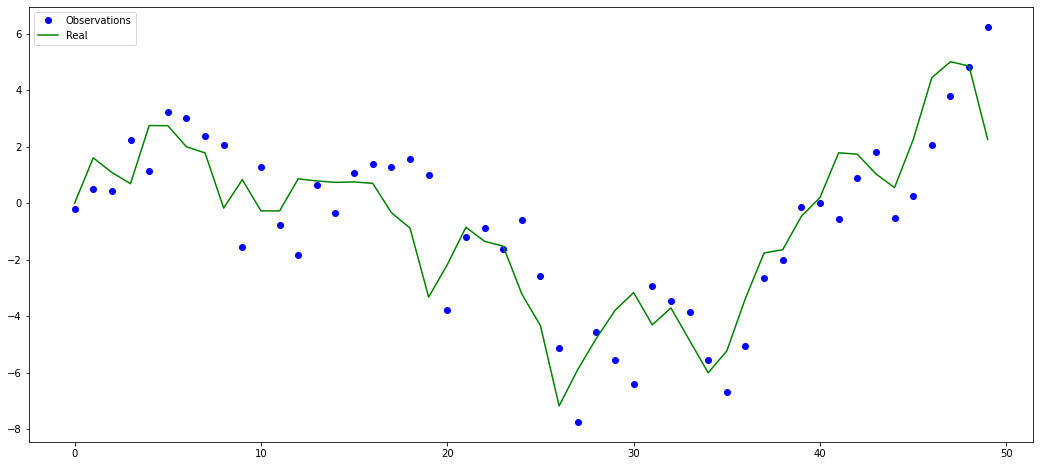

In [563]:
# Define parameters
num_particles = 1000
alpha = 0.95
sigma_v = 1.0
sigma_w = 1.0

T = 50 # Define the number of time steps
time = np.arange(T) # Create a time vector 

# True object motion model
def f(x):
    return alpha*x + np.random.normal(0, sigma_v)

# Observation model
def g(x):
    return x + np.random.normal(0, sigma_w)

# Observations
X_real = np.zeros(T)
Y_obs = np.zeros(T)
X_real[0] = 0
Y_obs[0] = g(X_real[0])
for t in range(1, T):
    X_real[t] = f(X_real[t-1])
    Y_obs[t] = g(X_real[t-1])
    
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.legend()
plt.show()

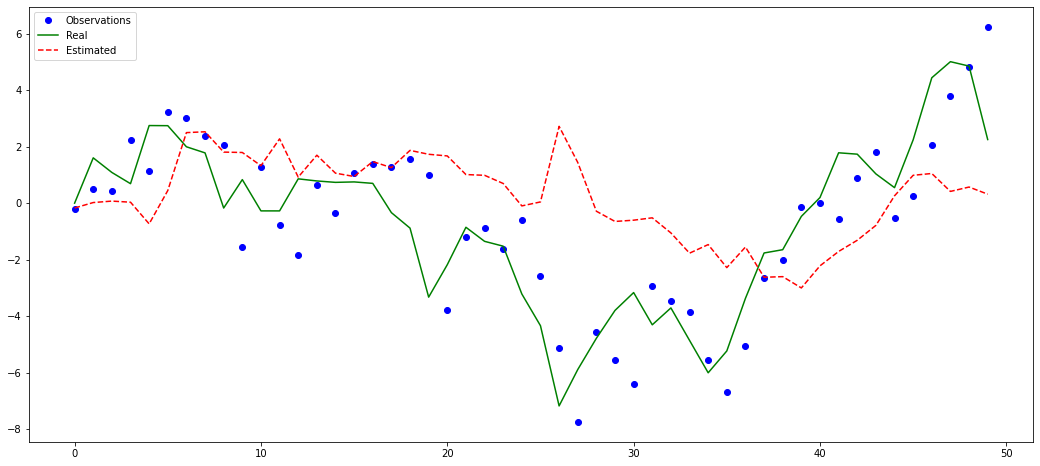

In [564]:
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states
estimated_states = []

# Time t=1
particles[:,0] = stats.norm(0,2).rvs(size=num_particles)
weights[:,0] = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[0] - particles[:, 0])**2 / (2 * sigma_w**2))
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()

ESS[0] = 1 / (norm_weights[:,0]**2).sum()

estimated_states.append(np.sum(particles[:, 0]*norm_weights[:,0]))

# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = f(particles[:, t - 1])

    # Update step: compute importance weights based on observation model
    incremental_weight = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[t] - particles[:, t])**2 / (2 * sigma_w**2))
    weights[:, t] = weights[:,t-1]*incremental_weight  
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    
    ESS[t]= 1 / np.sum(norm_weights**2)

    # Compute estimated state (weighted mean of particles)
    estimated_states.append(np.sum(particles[:, t] * norm_weights[:, t]))
    
# Plot results
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.plot(time, estimated_states, 'r--', label='Estimated')
plt.legend()
plt.show()

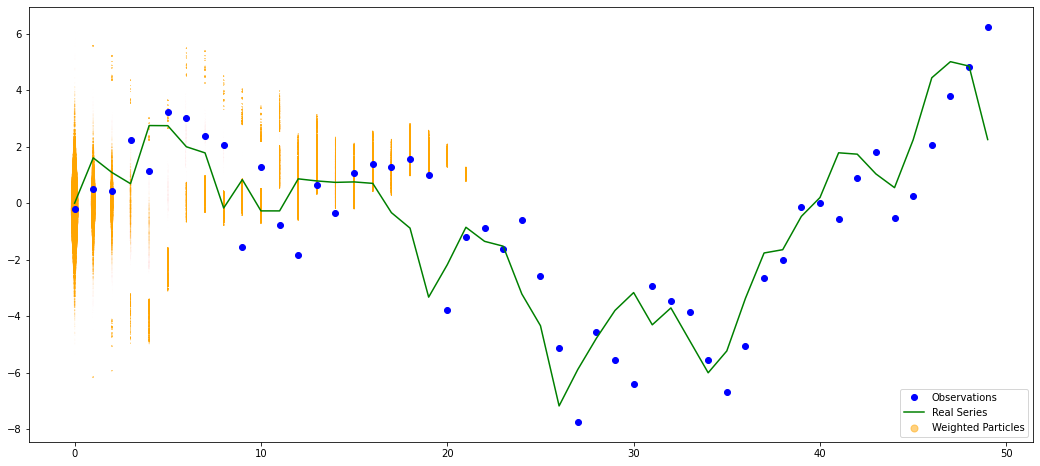

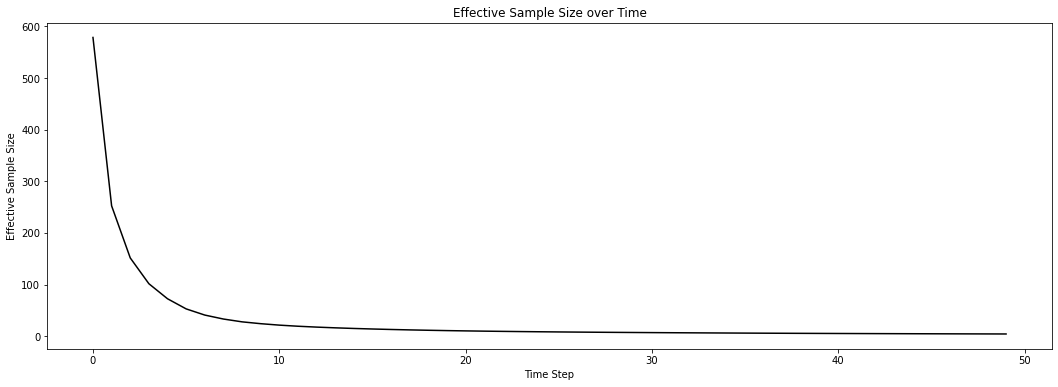

In [565]:
# Plot results
plt.figure(figsize=(18, 8))
# Plot observations
plt.plot(time, Y_obs, 'b o', label='Observations')

# Plot real state
plt.plot(time, X_real, 'g', label='Real Series')

# Plot weighted particles
for t in range(T):
    sizes = 100 * weights[:, t]  # Use weights to determine marker size (scaled for better visibility)
    plt.scatter([time[t]] * num_particles, particles[:, t], s=sizes, c='orange', alpha=0.5)

plt.scatter([], [], s=50, c='orange', alpha=0.5, label='Weighted Particles')
plt.legend()
plt.show()

# Plot ESS in a separate chart
plt.figure(figsize=(18, 6))
plt.plot(time, ESS, color='black')
plt.xlabel('Time Step')
plt.ylabel('Effective Sample Size')
plt.title('Effective Sample Size over Time')
plt.show()


### Botstrap Particle Filter

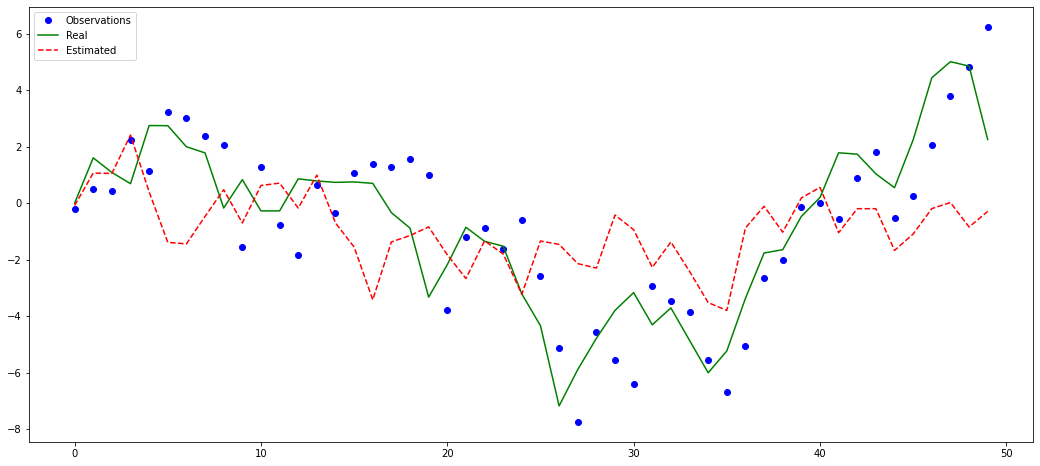

In [588]:
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states
estimated_states = []

# Time t=1
particles[:,0] = stats.norm(0,1).rvs(size=num_particles)
weights[:,0] = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[0] - particles[:, 0])**2 / (2 * sigma_w**2))
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()

ESS[0] = 1 / (norm_weights[:,0]**2).sum()
estimated_states.append(np.sum(particles[:, 0]*norm_weights[:,0]))

# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = f(particles[:, t - 1])

    # Update step: compute importance weights based on observation model
    incremental_weight = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[t] - particles[:, t])**2 / (2 * sigma_w**2))
    weights[:, t] = weights[:,t-1]*incremental_weight  
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    
    ESS[t]= 1 / np.sum(norm_weights**2)
    if ESS[t] < num_particles/10:
        # Update particles and weights based on resampled indices
        resampled_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:, t])
        particles[:, t] = particles[resampled_indices, t]
        weights[:, t] = 1 / num_particles  # Reset weights to uniform distribution after resampling
        norm_weights[:, t] = weights[:,t]
        # Compute estimated state (weighted mean of particles)
        estimated_states.append(np.sum(particles[:, t] * norm_weights[:, t]))
    else:
        estimated_states.append(np.sum(particles[:, t] * norm_weights[:, t]))
    
# Plot results
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.plot(time, estimated_states, 'r--', label='Estimated')
plt.legend()
plt.show()

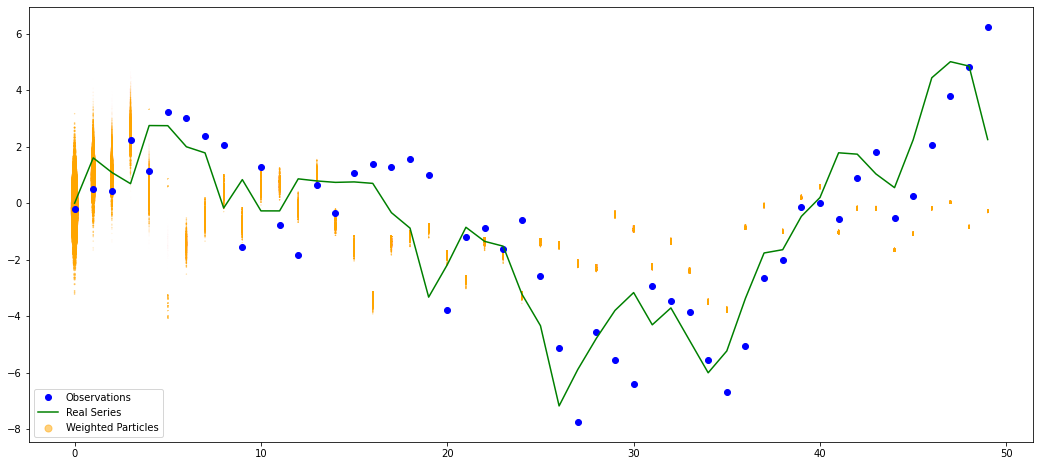

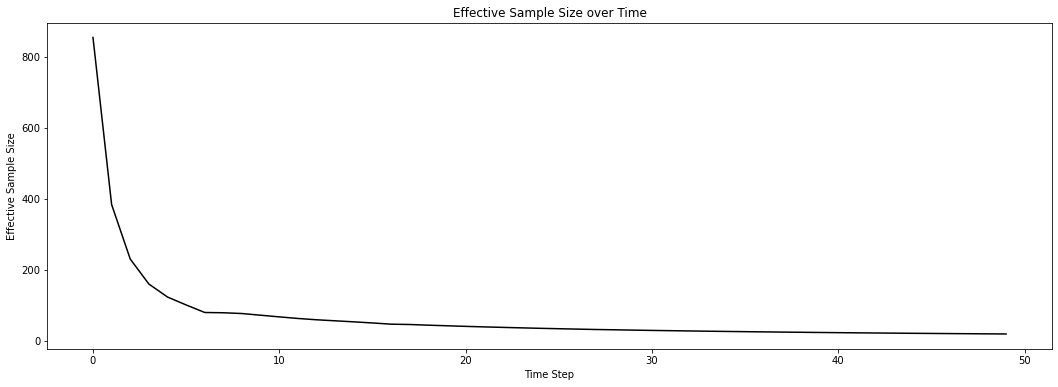

In [589]:
# Plot results
plt.figure(figsize=(18, 8))
# Plot observations
plt.plot(time, Y_obs, 'b o', label='Observations')

# Plot real state
plt.plot(time, X_real, 'g', label='Real Series')

# Plot weighted particles
for t in range(T):
    sizes = 100 * weights[:, t]  # Use weights to determine marker size (scaled for better visibility)
    plt.scatter([time[t]] * num_particles, particles[:, t], s=sizes, c='orange', alpha=0.5)

plt.scatter([], [], s=50, c='orange', alpha=0.5, label='Weighted Particles')
plt.legend()
plt.show()

# Plot ESS in a separate chart
plt.figure(figsize=(18, 6))
plt.plot(time, ESS, color='black')
plt.xlabel('Time Step')
plt.ylabel('Effective Sample Size')
plt.title('Effective Sample Size over Time')
plt.show()

## MCMC Example

Lets assume we are interested in estimating the bias of a coin.

In [690]:
num_tosses = 20
num_heads = 14

data = stats.binom(1,num_heads/num_tosses).rvs(100)

def prior(x):
    a=b=1 #non informative prior
    return stats.beta(a,b).pdf(x)

def likelihood(theta, data):
    trials = len(data)
    heads = data.sum()
    return theta**heads * (1-theta)**(trials - heads)

num_iterations = 8000
burnin = 2000
#initialize chain
theta = np.zeros(num_iterations+burnin)
theta[0] = 0.5

for t in range(1,num_iterations+burnin):
    theta_new = stats.norm(theta[t-1],0.05).rvs()
    prior_ratio = prior(theta_new) / prior(theta[t-1])
    like_ratio = likelihood(theta_new, data) / likelihood(theta[t-1], data)
    acceptance_ratio = min(1,prior_ratio*like_ratio)
    
    u = stats.uniform(0,1).rvs()
    if u <= acceptance_ratio:
        theta[t] = theta_new
    else:
        theta[t] = theta[t-1]

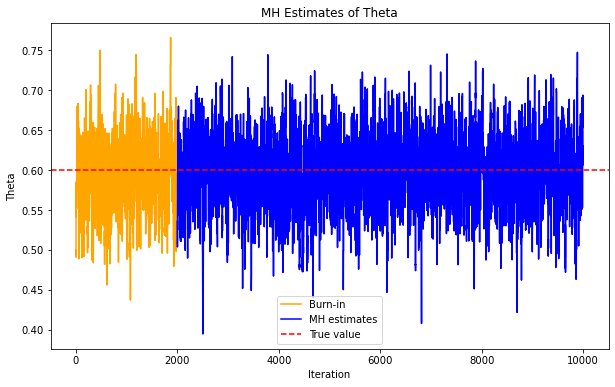

In [691]:
plt.figure(figsize=(10, 6))

# Plot the burn-in period in a different color
plt.plot(np.arange(burnin), theta[:burnin], color='orange', label='Burn-in')

# Plot the remaining iterations after burn-in in blue
plt.plot(np.arange(burnin, num_iterations + burnin), theta[burnin:], color='blue', label='MH estimates')

# Plot the true value of theta
plt.axhline(y=data.sum()/len(data), color='red', linestyle='--', label='True value')

plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.title('MH Estimates of Theta')
plt.legend()
plt.show()

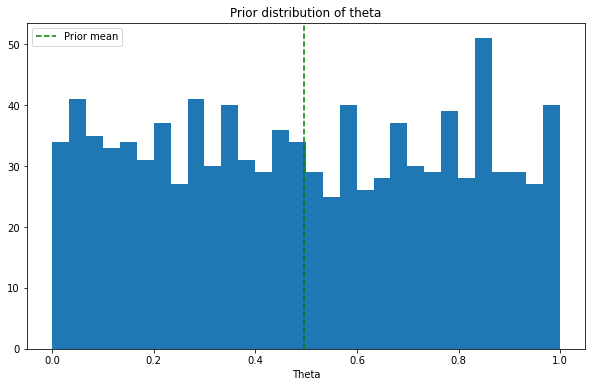

In [692]:
# Generate a range of values for theta
prior_values = stats.beta(1,1).rvs(1000)
# Plot the prior distribution
plt.figure(figsize=(10, 6))
plt.hist(prior_values, bins = 30)
plt.axvline(x=np.mean(prior_values), color='green', linestyle='--', label='Prior mean')
plt.xlabel('Theta')
plt.title('Prior distribution of theta')
plt.legend()
plt.show()

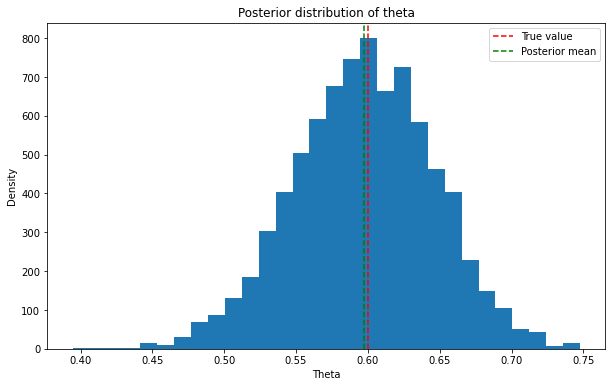

In [693]:
plt.figure(figsize=(10, 6))
plt.hist(theta[-num_iterations:], bins = 30)
plt.axvline(x=data.sum()/len(data), color='red', linestyle='--', label='True value')
plt.axvline(x=np.mean(theta[burnin:]), color='green', linestyle='--', label='Posterior mean')

plt.xlabel('Theta')
plt.ylabel('Density')
plt.title('Posterior distribution of theta')
plt.legend()
plt.show()

In [751]:
num_chains = 4  # Number of chains
chain_length = num_iterations + burnin

# Initialize an array to store all chains
chains = np.zeros((num_chains, chain_length))

# Loop through each chain
for chain_index in range(num_chains):
    # Initialize chain
    chains[chain_index][0] = stats.uniform(0.15,0.85).rvs(1)+stats.norm(0,0.1).rvs(1)
    
    # Generate chain samples
    for t in range(1, chain_length):
        theta_new = stats.norm(chains[chain_index][t-1], 0.05).rvs()
        prior_ratio = prior(theta_new) / prior(chains[chain_index][t-1])
        like_ratio = likelihood(theta_new, data) / likelihood(chains[chain_index][t-1], data)
        acceptance_ratio = min(1, prior_ratio * like_ratio)

        u = stats.uniform(0, 1).rvs()
        if u <= acceptance_ratio:
            chains[chain_index][t] = theta_new
        else:
            chains[chain_index][t] = chains[chain_index][t-1]

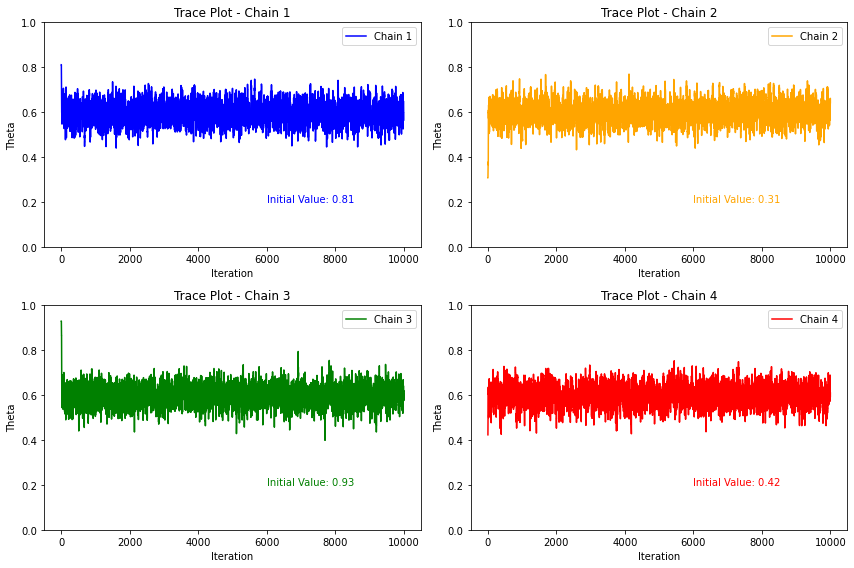

In [754]:
plt.figure(figsize=(12, 8))

# Define a list of colors for each chain
colors = ['blue', 'orange', 'green', 'red']

for chain_index in range(num_chains):
    plt.subplot(2, 2, chain_index+1)
    plt.plot(chains[chain_index], label=f'Chain {chain_index+1}', color=colors[chain_index])
    plt.text(6000, 0.2, f'Initial Value: {chains[chain_index][0]:.2f}', color=colors[chain_index])
    plt.xlabel('Iteration')
    plt.ylabel('Theta')
    plt.ylim(0, 1)
    plt.title(f'Trace Plot - Chain {chain_index+1}')
    plt.legend()

plt.tight_layout()
plt.show()

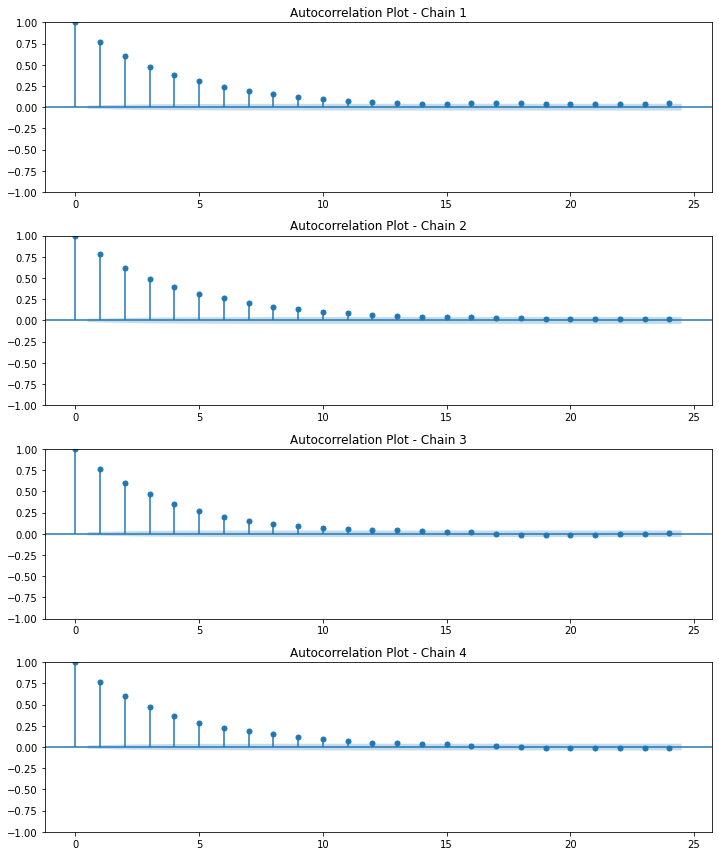

In [736]:
import statsmodels.api as sm

plt.figure(figsize=(10, 12))
for chain_index in range(num_chains):
    sm.graphics.tsa.plot_acf(chains[chain_index], lags=24, ax=plt.subplot(num_chains, 1, chain_index+1))
    plt.title(f'Autocorrelation Plot - Chain {chain_index+1}')

plt.tight_layout()
plt.show()